# CNV Diversity
## How many CNV events occur in the chemostat?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

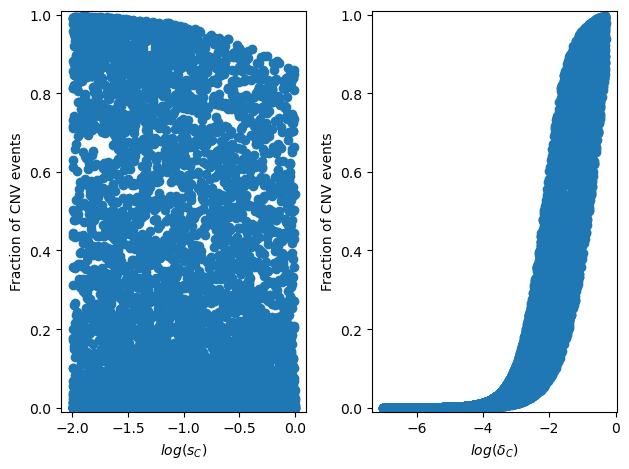

In [8]:
# Pre-simulated data - 10k simulations
# Each simulation's output is the comulative number of CNV events
div_df = pd.read_csv('presimulated_data/WF_presimulated_data_10000_diversity.csv', header=None)
div_df.columns = ['CNVs']

# Simulated parameters
div_theta = pd.read_csv('presimulated_data/WF_presimulated_theta_10000_diversity.csv', header=None).iloc[:,:-1]
div_theta.columns = ['$log(s_C)$', '$log(δ_C)$']

# Plotting CNV events as a function of model parameters
fig, ax = plt.subplots(1,2, tight_layout=True)
N = float(3.3e8)
for i in range(len(div_theta.columns)):
    c = div_theta.columns[i]
    ax[i].scatter(div_theta[c],div_df['CNVs'].astype(float) / N)
    ax[i].set_xlabel(c)
    ax[i].set_ylabel('Fraction of CNV events')
    ax[i].set_ylim(-0.01,1.01)

# CNV Events by $\delta_C$
## Assuming no selection, the total number of CNV events can be approximated by a geometric sum:
### $N_{cnv} \approx \delta_C + \delta_C*(1-\delta_C-\delta_B) + \delta_C*{(1-\delta_C-\delta_B)^2}+...=$
### $ = { {\delta_C*{[1-(1-\delta_C-\delta_B)^{T}]}} \over {\delta_C+\delta_B} }$

Text(0, 0.5, 'Total CNV events')

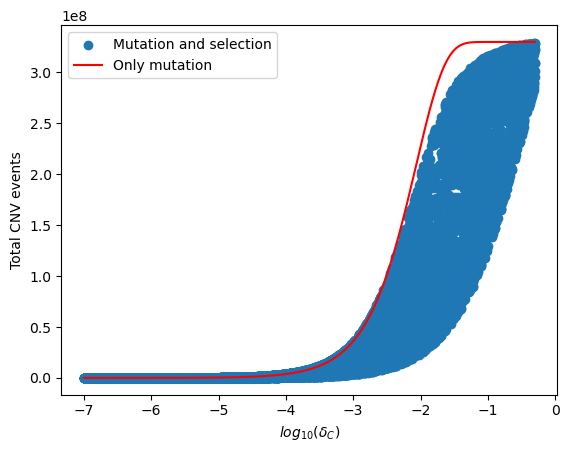

In [4]:
plt.scatter(div_theta['$log(δ_C)$'],div_df['CNVs'].astype(float), label='Mutation and selection')

x = 10**div_theta['$log(δ_C)$'].sort_values()
y = x*((1-x-(10**-5))**116-1)/(-x-(10**-5))
plt.plot(np.log10(x),y*N, color='red', label = 'Only mutation')
plt.legend()
# plt.ylim(0,5e6)
plt.xlabel('$log_{10}(δ_C)$')
plt.ylabel('Total CNV events')
# plt.xlim(-6,-3)

# CNV events distribution estimation

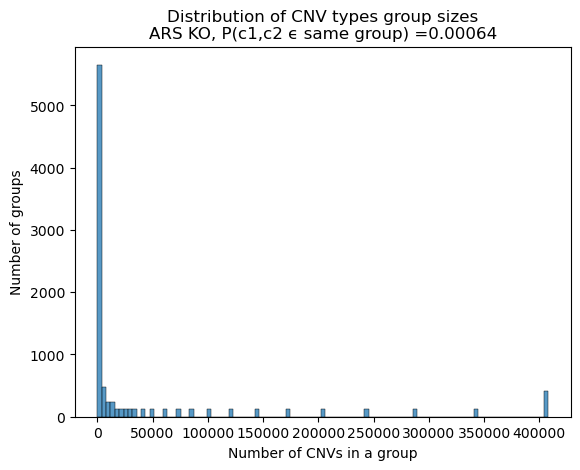

In [6]:
from diversity import simpleWF
from seaborn import histplot as hst

def calc_c1_c2_prob(s_cnv,m_cnv,p_0,max_possible):
    N=3.3e8
    generation = pd.read_csv(f'Chuong_116_gens.txt', delimiter = ', ', engine='python').columns.astype('int')
    N,P = simpleWF(N, generation, s_cnv, m_cnv, p_0,max_possible)
    N,P = N[N>1], P[N>1]
    X = P.sum()
    tot_P = 0
    dist_list = []
    for t in range(len(N)):
        tot_P += (P[t]**2/N[t])/X**2
        dist_list = dist_list + [P[t]/N[t] for i in range(int(N[t]))]
    
    hst(dist_list, stat='count', bins=len(N))
    plt.xlabel('Number of CNVs in a group')
    plt.ylabel('Number of groups')
    plt.title(f'Distribution of CNV types group sizes\nARS KO, P(c1,c2 ϵ same group) ={round(tot_P,5)}')
    return tot_P

p = calc_c1_c2_prob(10**-0.72, 10**-6.44, 10**-6.04, np.inf)